## Scripts for testing different models

### Import datasets

In [1]:
import numpy as np
import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Activation, UpSampling2D, Conv2D, LeakyReLU, AveragePooling2D, Flatten,Reshape,Conv2DTranspose, ReLU
from keras.optimizers import RMSprop
from keras.initializers import RandomNormal

from keras.utils import generic_utils, np_utils
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from PIL import Image
import time
import math
from keras import layers
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import datasets
#define datatsets
def load_capacitive_data(dirname = "Verifinger_SDK_Code/FINGERPRINT_DATASETS/DB7AuthentecCapacitivePress/"):   # change the path to match your own
    imgs_names = os.listdir(dirname)
    
    #Prep Images
    X = []
    Y = []
    with tqdm(total=len(imgs_names)) as pbar:
        for i in imgs_names:
            if(i.endswith('.BMP')):
                im = Image.open(dirname + i)
                im = im.crop((8, 8, 136, 136))
                im = im.convert('L')
                im = img_to_array(im)
                im = (255 - im) / 255.0    #normalize [0,1]
                #im = (127.5-im) / 127.5   #normalize [-1,1]


                Y.append(i)
                X.append(im)
            pbar.update(1)
    
    X_train = np.array(X)
    Y_train = np.array(Y)
    
    return X_train, Y_train

def load_optical_data(dirname = "optical/"):   # change the path to match your own
    imgs_names = os.listdir(dirname)
    
    #Prep Images
    X = []
    Y = []
    with tqdm(total=len(imgs_names)) as pbar:
        for i in imgs_names:
            if(i.endswith('.tif')):
                im = Image.open(dirname + i)
                im = im.convert('L')
                im = img_to_array(im)
                im = (255 - im) / 255.0    #normalize [0,1]
                #im = (127.5-im) / 127.5   #normalize [-1,1]

                Y.append(i)
                X.append(im)
            pbar.update(1)
    
    X_train = np.array(X)
    Y_train = np.array(Y)
    
    return X_train, Y_train

def load_nist_data(s = 256, dirname = "nist/Right Thumbs/", randcrop=True, rcs=128):  # change the path to match your own
    imgs_names = os.listdir(dirname)
    
    #Prep Images
    X = []
    Y = []
    with tqdm(total=len(imgs_names)) as pbar:
        for i in imgs_names:
            im = Image.open(dirname + i)
            if(im.size[0] >= s and im.size[1] > s):
                Y.append(i)
                xi = resize(im,s)
                if randcrop:
                    xi = random_crop(np.expand_dims(xi,axis=0),rcs)[0]
                X.append(xi)
            pbar.update(1)
    
    X_train = np.array(X)
    Y_train = np.array(Y)
    
    return X_train, Y_train

def random_crop(img,crop_size):
    x, y = (np.random.randint(0, img.shape[1] - crop_size) for i in range(2))
    return img[:, x:x + crop_size, y:y + crop_size]

#resize
def resize(img, s):
    if(img.size[0] > img.size[1]):
        h = s
        ratio = h/float(img.size[1])
        w = int(img.size[0]*ratio)
        img = img.resize((w,h), Image.ANTIALIAS)
        
        border = int((w - s)/2)
        img = img.crop((border, 0, border + s, h))
    else:
        w = s
        ratio = w/float(img.size[0])
        h = int(img.size[1]*ratio)
        img = img.resize((w,h), Image.ANTIALIAS)
        
        border = int((h - s)/2)
        img = img.crop((0, border, w, border + s))
        
    img = img.convert('L')    
    #img = preK.img_to_array(img, 'tf')
    img = img_to_array(img)
    img = (255 - img) / 255.0    #normalize [0,1]
    #img = (127.5-img) / 127.5   #normalize [-1,1]
    
    return img

In [3]:
X_train = []
y_train = []

DATASET = "CAPACITIVE"


if DATASET == "CAPACITIVE":
    X_train, y_train = load_capacitive_data()
elif DATASET == "OPTICAL":
    X_train, y_train = load_optical_data()
elif DATASET == "NIST":
    X_train, y_train = load_nist_data()

#verify shape and datapoints
print(X_train[0].shape)
print(f"[{np.amin(X_train[:10])},{np.amax(X_train[:10])}]")

100%|██████████| 26047/26047 [00:02<00:00, 9130.75it/s]


(128, 128, 1)
[0.0,1.0]


### Train Autoencoder

https://www.tensorflow.org/tutorials/generative/autoencoder

In [8]:
from tensorflow.keras.models import Model

class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Sequential([
            layers.InputLayer(input_shape=(128, 128, 1)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def exportEnc(self):
        self.encoder.save(f"autoencoder_models/print_{DATASET}_encoder.h5")
        
    def importEnc(self):
        self.encoder = keras.models.load_model(f"autoencoder_models/print_{DATASET}_encoder.h5")
        
    def exportDec(self):
        self.decoder.save(f"autoencoder_models/print_{DATASET}_decoder.h5")
        
    def importDec(self):
        self.decoder = keras.models.load_model(f"autoencoder_models/print_{DATASET}_decoder.h5")
        

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [9]:
#train
#with tf.device("/device:GPU:0"):
autoencoder.fit(X_train, X_train,epochs=100,shuffle=True)

Epoch 1/100
270/270 [==============================] - 177s 618ms/step - loss: 0.1516 - accuracy: 0.4410
Epoch 2/100
270/270 [==============================] - 168s 620ms/step - loss: 0.1152 - accuracy: 0.5156
Epoch 3/100
270/270 [==============================] - 167s 620ms/step - loss: 0.1096 - accuracy: 0.5247
Epoch 4/100
270/270 [==============================] - 168s 621ms/step - loss: 0.1071 - accuracy: 0.5285
Epoch 5/100
270/270 [==============================] - 168s 622ms/step - loss: 0.1057 - accuracy: 0.5304
Epoch 6/100
270/270 [==============================] - 168s 621ms/step - loss: 0.1048 - accuracy: 0.5316
Epoch 7/100
270/270 [==============================] - 167s 620ms/step - loss: 0.1041 - accuracy: 0.5325
Epoch 8/100
270/270 [==============================] - 167s 620ms/step - loss: 0.1036 - accuracy: 0.5333
Epoch 9/100
270/270 [==============================] - 168s 621ms/step - loss: 0.1031 - accuracy: 0.5340
Epoch 10/100
270/270 [==============================] -

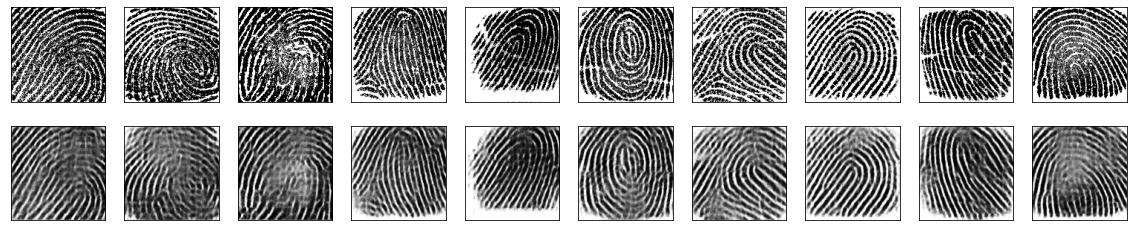

In [354]:
#before and after
n = 10
plt.figure(figsize=(20, 4))

encoded_imgs = autoencoder.encoder.predict(X_train[:n])
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i],cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i],cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
autoencoder.exportEnc()
autoencoder.exportDec()

In [35]:
def randSamp():
    return np.random.rand(1,8,8,8)*30.0

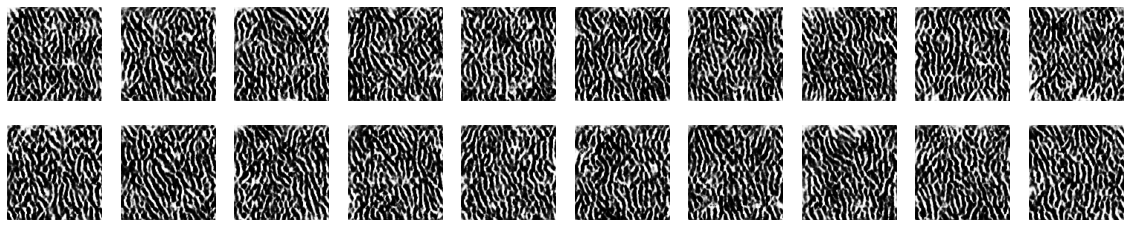

In [353]:
# create figure
plt.figure(figsize=(20, 4))

for i in range(20):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(autoencoder.decoder(randSamp())[0],cmap='binary')
    plt.axis('off')

### Train Variational Autoencoder

https://keras.io/examples/generative/vae/
Modified: https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8

In [186]:
# from tensorflow.keras.models import Model


# class Sampling(layers.Layer):
#     """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
#     def call(self, inputs):
#         z_mean, z_log_var = inputs
        
#         #get batch size and dimension of the inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
        
#         #perform sampling
#         epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# class VAE(Model):
#     def __init__(self):
#         super(VAE, self).__init__()
        
#         self.latent_dim = 2
        
#         #normal encoder
#         enc_in = keras.Input(shape=(128, 128, 1))
        
#         x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(enc_in)
#         x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
#         x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
#         x = layers.Flatten()(x)
#         x = layers.Dense(16, activation="relu")(x)
        
#         #variational sampling
#         z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
#         z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
#         z = Sampling()([z_mean, z_log_var])
            
#         #combine together
#         self.encoder = keras.Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        
#         #normal decoder
#         self.decoder = Sequential([
#             layers.InputLayer(input_shape=(self.latent_dim,)),
#             layers.Dense(16*16*16, activation="relu"),
#             layers.Reshape((16,16,16)),
#             layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
#             layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
#             layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
#             layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])
        
#         self.encoder.summary()
#         self.decoder.summary()

#     def train_step(self, data):
#         with tf.GradientTape() as tape:
#             z_mean, z_log_var, z = self.encoder(data)
#             reconstruction = self.decoder(z)
            
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            
#             #VAE loss function - MSE + KL DIVERGENCE
#             kl_loss = -0.5 * (1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
#             total_loss = reconstruction_loss + kl_loss
                
#         #apply loss back to weights
#         grads = tape.gradient(total_loss, self.trainable_weights)
#         self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
#         return {"recon loss":reconstruction_loss, "kl loss":kl_loss, "total loss": total_loss}

#     def exportEnc(self):
#         self.encoder.save(f"autoencoder_models/print_{DATASET}_var_encoder.h5")
        
#     def importEnc(self):
#         self.encoder = keras.models.load_model(f"autoencoder_models/print_{DATASET}_var_encoder.h5")
        
#     def exportDec(self):
#         self.decoder.save(f"autoencoder_models/print_{DATASET}_var_decoder.h5")
        
#     def importDec(self):
#         self.decoder = keras.models.load_model(f"autoencoder_models/print_{DATASET}_var_decoder.h5")
        
        

# vae = VAE()
# vae.compile(optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [6]:
from tensorflow.keras.models import Model
from keras import backend as K

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        mean_mu, log_var = inputs
        epsilon = keras.backend.random_normal(shape=keras.backend.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + keras.backend.exp(log_var/2)*epsilon

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.latent_dim = 5
        
        #variational encoder
        enc_in = keras.Input(shape=(128, 128, 1))
        
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(enc_in)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
        x = layers.LeakyReLU()(x)
#         x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
#         x = layers.LeakyReLU()(x)
        x = layers.Flatten()(x)
        
        #variational sampling
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
            
        #combine together
        self.encoder = keras.Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        
        #normal decoder
        dec_in = keras.Input(shape=(self.latent_dim,))
        y = layers.Dense(32*32*32, activation="relu")(dec_in)
        y = layers.Reshape((32,32,32))(y)
#         y = layers.Dense(16*16*16, activation="relu")(dec_in)
#         y = layers.Reshape((16,16,16))(y)
#         y = layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(y)
#         y = LeakyReLU()(y)
        y = layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same')(y)
        y = LeakyReLU()(y)
        y = layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation='relu', padding='same')(y)
        y = LeakyReLU()(y)
        dec_out = layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(y)
        self.decoder = keras.Model(dec_in, dec_out)

        
        self.encoder.summary()
        self.decoder.summary()
     
    #define loss functions
    
    #reconstructed loss
    def r_loss(self,y_true, y_pred):
        return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
        
    #kl-divergence loss
    def kl_loss(self,log_var, mean):
        kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
        return kl_loss

    #combined loss
    def total_loss(self,y_true, y_pred):
        LOSS_FACTOR = 10000
        return LOSS_FACTOR*self.r_loss(y_true, y_pred) + self.kl_loss(y_true, y_pred)

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            #get output encoding and reconstruct from latent vector
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #VAE loss function - MSE + KL DIVERGENCE
            reconstruction_loss = self.r_loss(data,reconstruction)
            kl_loss = self.kl_loss(z_log_var,z_mean)
            total_loss = 10000*reconstruction_loss+kl_loss
                
        #apply loss back to weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"recon loss":reconstruction_loss, "kl loss":kl_loss, "total loss": total_loss}
    

    def exportEnc(self):
        self.encoder.save(f"autoencoder_models/print_{DATASET}_var_encoder-TINY.h5")
        
    def importEnc(self):
        self.encoder = keras.models.load_model(f"autoencoder_models/print_{DATASET}_var_encoder-TINY.h5")
        
    def exportDec(self):
        self.decoder.save(f"autoencoder_models/print_{DATASET}_var_decoder-TINY.h5")
        
    def importDec(self):
        self.decoder = keras.models.load_model(f"autoencoder_models/print_{DATASET}_var_decoder-TINY.h5")
        

vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005), metrics=['accuracy', vae.r_loss, vae.kl_loss])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   18464       leaky_re_lu[0][0]                
____________________________________________________________________________________________

/home/jupyter/anaconda3/envs/DeepPrint2/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
s = np.expand_dims(X_train[0],axis=0)
#print(vae.encoder(s))
#plt.imshow(vae.decoder(vae.encoder(s)[2])[0],cmap='binary')

In [8]:
#train
#with tf.device("/device:GPU:0"):
vae.fit(X_train,epochs=100,batch_size=16,shuffle=True)

Epoch 1/100
540/540 [==============================] - 30s 55ms/step - recon loss: 0.1664 - kl loss: 6.4513 - total loss: 1670.0901
Epoch 2/100
540/540 [==============================] - 29s 54ms/step - recon loss: 0.1581 - kl loss: 9.0027 - total loss: 1589.8800
Epoch 3/100
540/540 [==============================] - 29s 54ms/step - recon loss: 0.1558 - kl loss: 9.5548 - total loss: 1567.7334
Epoch 4/100
540/540 [==============================] - 29s 54ms/step - recon loss: 0.1547 - kl loss: 9.8661 - total loss: 1556.4006
Epoch 5/100
540/540 [==============================] - 29s 54ms/step - recon loss: 0.1540 - kl loss: 10.0687 - total loss: 1549.6443
Epoch 6/100
540/540 [==============================] - 29s 54ms/step - recon loss: 0.1535 - kl loss: 10.2013 - total loss: 1545.0740
Epoch 7/100
540/540 [==============================] - 29s 54ms/step - recon loss: 0.1531 - kl loss: 10.2857 - total loss: 1541.7542
Epoch 8/100
540/540 [==============================] - 29s 54ms/step - re

540/540 [==============================] - 31s 58ms/step - recon loss: 0.1513 - kl loss: 10.8152 - total loss: 1524.1438
Epoch 63/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1513 - kl loss: 10.8020 - total loss: 1524.1815
Epoch 64/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1513 - kl loss: 10.8664 - total loss: 1524.0186
Epoch 67/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1513 - kl loss: 10.8452 - total loss: 1524.0317
Epoch 68/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1513 - kl loss: 10.8684 - total loss: 1523.8462
Epoch 69/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1513 - kl loss: 10.8599 - total loss: 1523.7218
Epoch 70/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1513 - kl loss: 10.8763 - total loss: 1523.7809
Epoch 71/100
540/540 [==============================] - 31s 58ms/step - rec

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



540/540 [==============================] - 31s 58ms/step - recon loss: 0.1512 - kl loss: 10.9462 - total loss: 1522.8052
Epoch 88/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1512 - kl loss: 10.9566 - total loss: 1522.4598
Epoch 89/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1512 - kl loss: 10.9583 - total loss: 1522.5332
Epoch 90/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1512 - kl loss: 10.9520 - total loss: 1522.4951
Epoch 91/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1511 - kl loss: 10.9567 - total loss: 1522.3304
Epoch 92/100
540/540 [==============================] - 31s 58ms/step - recon loss: 0.1512 - kl loss: 11.0035 - total loss: 1522.5065
Epoch 93/100
194/540 [=========>....................] - ETA: 20s - recon loss: 0.1514 - kl loss: 11.0440 - total loss: 1525.5170

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



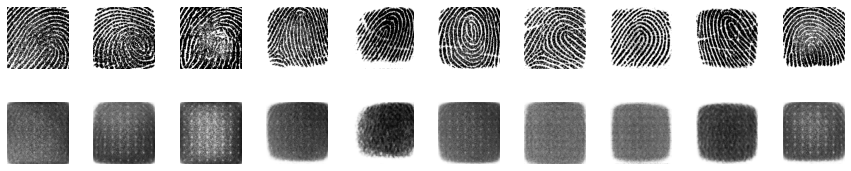

In [9]:
def plot_compare_vae(images=None):
    n_to_show = images.shape[0]
    reconst_images = vae.decoder.predict(vae.encoder(images)[2])

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='binary')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='binary')  

    plt.show()

plot_compare_vae(images = X_train[:10]) 

In [ ]:
#show randomly generated prints (random latent vecotr fed to the decoder)
def vae_generate_images(vae,n_to_show=20):
    reconst_images = vae.decoder.predict(np.random.normal(0,1,size=(n_to_show,100)))

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='binary')

vae_generate_images(vae,10) 

### Optical

100%|██████████| 5201/5201 [00:46<00:00, 110.79it/s]


(128, 128, 1)
[0.0,0.886274516582489]


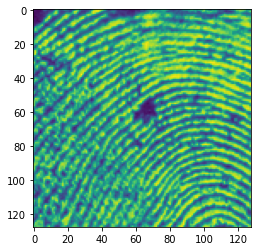

In [59]:
X_train = []
y_train = []

DATASET = "OPTICAL"


if DATASET == "CAPACITIVE":
    X_train, y_train = load_capacitive_data()
elif DATASET == "OPTICAL":
    X_train, y_train = load_optical_data()
elif DATASET == "NIST":
    X_train, y_train = load_nist_data()

#verify shape and datapoints
plt.imshow(X_train[0])
print(X_train[0].shape)
print(f"[{np.amin(X_train[:10])},{np.amax(X_train[:10])}]")

#### AUTOENCODER

In [60]:
from tensorflow.keras.models import Model

class Autoencoder2(Model):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = Sequential([
            layers.InputLayer(input_shape=(128, 128, 1)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = Sequential([
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def exportEnc(self):
        self.encoder.save(f"autoencoder_models/print_{DATASET}_encoder.h5")
        
    def importEnc(self):
        self.encoder = keras.models.load_model(f"autoencoder_models/print_{DATASET}_encoder.h5")
        
    def exportDec(self):
        self.decoder.save(f"autoencoder_models/print_{DATASET}_decoder.h5")
        
    def importDec(self):
        self.decoder = keras.models.load_model(f"autoencoder_models/print_{DATASET}_decoder.h5")
        
ae_nist = Autoencoder2()
ae_nist.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [333]:
#train
#with tf.device("/device:GPU:0"):
ae_nist.fit(X_train, X_train,epochs=100,shuffle=True)

Epoch 1/100
157/157 [==============================] - 97s 615ms/step - loss: 0.0187 - accuracy: 5.4961e-04
Epoch 2/100
157/157 [==============================] - 97s 615ms/step - loss: 0.0093 - accuracy: 5.5040e-04
Epoch 3/100
157/157 [==============================] - 97s 615ms/step - loss: 0.0067 - accuracy: 5.5040e-04
Epoch 4/100
157/157 [==============================] - 97s 615ms/step - loss: 0.0056 - accuracy: 5.5040e-04
Epoch 5/100
157/157 [==============================] - 97s 616ms/step - loss: 0.0049 - accuracy: 5.5040e-04
Epoch 6/100
157/157 [==============================] - 97s 615ms/step - loss: 0.0046 - accuracy: 5.5040e-04
Epoch 7/100
157/157 [==============================] - 97s 616ms/step - loss: 0.0041 - accuracy: 5.5040e-04
Epoch 8/100
157/157 [==============================] - 97s 615ms/step - loss: 0.0038 - accuracy: 5.5040e-04
Epoch 9/100
157/157 [==============================] - 97s 616ms/step - loss: 0.0037 - accuracy: 5.5040e-04
Epoch 10/100
157/157 [======

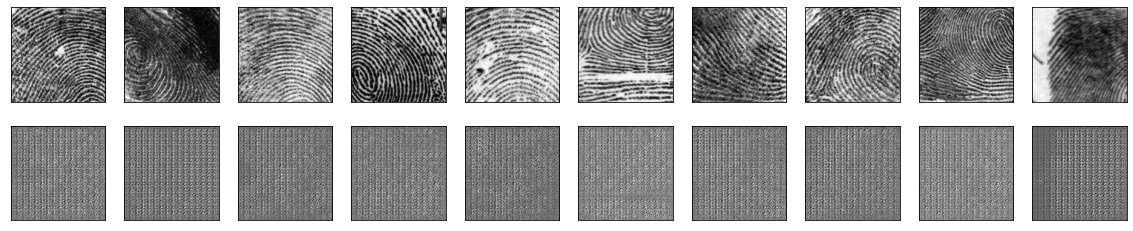

In [61]:
#before and after
n = 10
plt.figure(figsize=(20, 4))

encoded_imgs = ae_nist.encoder.predict(X_train[:n])
decoded_imgs = ae_nist.decoder.predict(encoded_imgs)

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i],cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i],cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [62]:
encoded_imgs[0].shape

(16, 16, 16)

In [65]:
ae_nist.exportEnc()
ae_nist.exportDec()

#### VARIATIONAL AUTOENCODER

In [66]:
vae_nist = VAE()
vae_nist.compile(optimizer=keras.optimizers.Adam(lr=0.0005), metrics=['accuracy', vae_nist.r_loss, vae_nist.kl_loss])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 64, 64, 64)   640         input_42[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_82 (LeakyReLU)      (None, 64, 64, 64)   0           conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 32, 32, 32)   18464       leaky_re_lu_82[0][0]             
____________________________________________________________________________________________

In [68]:
#train
#with tf.device("/device:GPU:0"):
vae_nist.fit(X_train[:-4],epochs=100,batch_size=16,shuffle=True)

Epoch 1/100
312/312 [==============================] - 96s 238ms/step - recon loss: 11023.7459 - kl loss: 15.9300 - total loss: 11039.6758
Epoch 2/100
312/312 [==============================] - 27s 85ms/step - recon loss: 10866.5198 - kl loss: 26.9915 - total loss: 10893.5112
Epoch 3/100
312/312 [==============================] - 26s 85ms/step - recon loss: 10841.6985 - kl loss: 29.0376 - total loss: 10870.7361
Epoch 4/100
312/312 [==============================] - 26s 85ms/step - recon loss: 10823.8754 - kl loss: 28.6432 - total loss: 10852.5186
Epoch 5/100
312/312 [==============================] - 27s 85ms/step - recon loss: 10815.0536 - kl loss: 27.6611 - total loss: 10842.7148
Epoch 6/100
312/312 [==============================] - 26s 84ms/step - recon loss: 10806.8455 - kl loss: 27.2062 - total loss: 10834.0516
Epoch 7/100
312/312 [==============================] - 26s 84ms/step - recon loss: 10805.1698 - kl loss: 26.9392 - total loss: 10832.1090
Epoch 8/100
312/312 [============

Epoch 60/100
312/312 [==============================] - 26s 85ms/step - recon loss: 10773.6391 - kl loss: 30.2196 - total loss: 10803.8587
Epoch 61/100
312/312 [==============================] - 26s 84ms/step - recon loss: 10772.5350 - kl loss: 30.2274 - total loss: 10802.7623
Epoch 62/100
312/312 [==============================] - 26s 84ms/step - recon loss: 10772.7183 - kl loss: 30.2873 - total loss: 10803.0055
Epoch 63/100
312/312 [==============================] - 26s 84ms/step - recon loss: 10773.2065 - kl loss: 30.2757 - total loss: 10803.4823
Epoch 64/100
312/312 [==============================] - 26s 84ms/step - recon loss: 10773.4565 - kl loss: 30.4758 - total loss: 10803.9323
Epoch 65/100
312/312 [==============================] - 27s 85ms/step - recon loss: 10772.3816 - kl loss: 30.4063 - total loss: 10802.7880
Epoch 66/100
312/312 [==============================] - 26s 84ms/step - recon loss: 10773.1465 - kl loss: 30.5235 - total loss: 10803.6700
Epoch 67/100
312/312 [=====

In [ ]:
def plot_compare_vae(images=None):
    n_to_show = images.shape[0]
    reconst_images = vae_nist.decoder.predict(vae.encoder(images)[2])

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='binary')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='binary')  

    plt.show()

plot_compare_vae(images = X_train[:10]) 

In [339]:
vae.encoder.predict(X_train[:1])[2].shape

(1, 100)

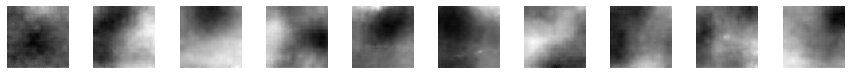

In [325]:
#show randomly generated prints (random latent vecotr fed to the decoder)
def vae_generate_images(n_to_show=20):
    reconst_images = vae_nist.decoder.predict(np.random.normal(0,1,size=(n_to_show,100)))

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='binary')

vae_generate_images(10) 

In [326]:
vae_nist.exportEnc()
vae_nist.exportDec()

### Special Variational Autoencoder 

In [51]:
from tensorflow.keras.models import Model
from keras import backend as K

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        mean_mu, log_var = inputs
        epsilon = keras.backend.random_normal(shape=keras.backend.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + keras.backend.exp(log_var/2)*epsilon

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.latent_dim = 100
        #tried with 20 dimensions but not good results
        
        #variational encoder
        enc_in = keras.Input(shape=(128, 128, 1))
        
        x = layers.Conv2D(64, (3, 3), padding='same', strides=2)(enc_in)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(32, (3, 3), padding='same', strides=2)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(16, (3, 3), padding='same', strides=2)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Flatten()(x)
        
        #variational sampling
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
            
        #combine together
        self.encoder = keras.Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        
        #normal decoder
        dec_in = keras.Input(shape=(self.latent_dim,))
#         y = layers.Dense(32*32*32, activation="relu")(dec_in)
#         y = layers.Reshape((32,32,32))(y)
        y = layers.Dense(16*16*16, activation="relu")(dec_in)
        y = layers.Reshape((16,16,16))(y)
        y = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(y)
        y = LeakyReLU()(y)
        y = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(y)
        y = LeakyReLU()(y)
        y = layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(y)
        y = LeakyReLU()(y)
        dec_out = layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(y)
        self.decoder = keras.Model(dec_in, dec_out)

        
        self.encoder.summary()
        self.decoder.summary()
     
    #define loss functions
    
    #reconstructed loss
    def r_loss(self,y_true, y_pred):
        r = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)
            )
        )
        return r
        
#         return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
        
    #kl-divergence loss
    def kl_loss(self,log_var, mean):
        #kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
        kl_l = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
        kl_l = tf.reduce_mean(tf.reduce_sum(kl_l, axis=1))
        return kl_l

#     #combined loss
#     def total_loss(self,y_true, y_pred):
#         LOSS_FACTOR = 10
#         return LOSS_FACTOR*self.r_loss(y_true, y_pred) + self.kl_loss(y_true, y_pred)

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            LF = 1
            
            #get output encoding and reconstruct from latent vector
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #VAE loss function - MSE + KL DIVERGENCE
            reconstruction_loss = self.r_loss(data,reconstruction)
            kl_loss = self.kl_loss(z_log_var,z_mean)
            total_loss = LF*reconstruction_loss+kl_loss
                
        #apply loss back to weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"recon loss":reconstruction_loss, "kl loss":kl_loss, "total loss": total_loss}
    

    def exportEnc(self,name=''):
        self.encoder.save(f"spec_autoencoder_models/print_{DATASET}_var_encoder-{name}.h5")
        
    def importEnc(self,name=''):
        self.encoder = keras.models.load_model(f"spec_autoencoder_models/print_{DATASET}_var_encoder-{name}.h5")
        
    def exportDec(self,name=''):
        self.decoder.save(f"spec_autoencoder_models/print_{DATASET}_var_decoder-{name}.h5")
        
    def importDec(self,name=''):
        self.decoder = keras.models.load_model(f"spec_autoencoder_models/print_{DATASET}_var_decoder-{name}.h5")
        

vae_sp = VAE()
vae_sp.compile(optimizer=keras.optimizers.Adam(lr=0.0005), metrics=['accuracy', vae.r_loss, vae.kl_loss])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 64, 64, 64)   640         input_37[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_70 (LeakyReLU)      (None, 64, 64, 64)   0           conv2d_52[0][0]                  
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 32, 32, 32)   18464       leaky_re_lu_70[0][0]             
____________________________________________________________________________________________

In [52]:
#train
#with tf.device("/device:GPU:0"):
vae_sp.fit(X_train,epochs=100,batch_size=16,shuffle=True)

Epoch 1/100
540/540 [==============================] - 32s 58ms/step - recon loss: 10680.8131 - kl loss: 41.4115 - total loss: 10722.2246
Epoch 2/100
540/540 [==============================] - 30s 55ms/step - recon loss: 10320.2247 - kl loss: 65.8471 - total loss: 10386.0718
Epoch 3/100
540/540 [==============================] - 30s 55ms/step - recon loss: 10266.6431 - kl loss: 66.7303 - total loss: 10333.3734
Epoch 4/100
540/540 [==============================] - 30s 56ms/step - recon loss: 10231.2055 - kl loss: 68.4665 - total loss: 10299.6720
Epoch 5/100
540/540 [==============================] - 30s 56ms/step - recon loss: 9961.1680 - kl loss: 118.9474 - total loss: 10080.1153
Epoch 6/100
540/540 [==============================] - 30s 56ms/step - recon loss: 9613.8654 - kl loss: 160.9225 - total loss: 9774.7879
Epoch 7/100
540/540 [==============================] - 29s 54ms/step - recon loss: 9470.3715 - kl loss: 170.0436 - total loss: 9640.4151
Epoch 8/100
540/540 [===============

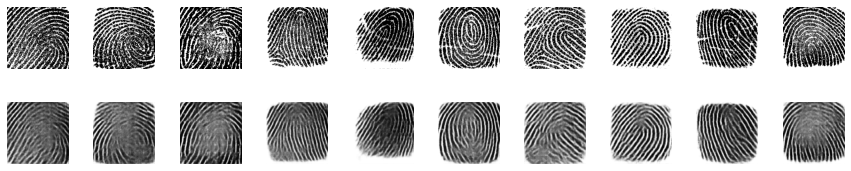

In [53]:
def plot_compare_vae(images=None):
    n_to_show = images.shape[0]
    reconst_images = vae_sp.decoder.predict(vae_sp.encoder(images)[2])

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='binary')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='binary')  

    plt.show()

plot_compare_vae(images = X_train[:10]) 